# PDS GROUP PROJECT

### Authors: 
-Emil Henricsson Ene

-Alessandro Elena 

-Alessandro Consiglio

-Alex Sofroniou

### Table of Contents
* [1. Introduction](#Introduction)
* [2. Data Preparation](#Data_Preparation)
    * [2.1. Import of modules](#Import_of_Modules)
    * [2.2. DataLoad, indexing and removal of missing values](#Data_loading_variable_creation_and_removal_of_unusual_symbols)
* [3. Exploratory Analysis](#Exploratory_Analysis)
    * [3.1. Feature Selection](#Feature_Selection)
    * [3.2. Correlation](#Correlation)
* [4. Data Pre-Processing](#Data_Pre-Processing)
    * [4.1. Smote Method](#SMOTE_Method)
    * [4.2. Test and Train set creation](#Train_Test)
* [5. Modelling](#Modelling)
    * [5.1 Models without boost](#No_boost)
      * [5.1.1 Decision Tree](#Decision_tree)
      * [5.1.2 Multiclass Logistic Regression](#Multi_logistic_regr)
      * [5.1.3 K-Nearest Neighbors](#knn)
    * [5.2 Results](#Results)
* [6. XGBoost Preparation](#Preparation)
    * [6.1 Hyperparameters Tuning](#Tuning)
* [7. XGBoost in Action](#Action)
    * [7.1 Results from Boosting](#Results_Boosting)
* [8. Conclusion](#Conclusion)

# 1. Introduction <a class="anchor" id="Introduction"></a>
The number of available Airbnb listings is ever increasing as more and more people realize the possible incomes from renting out their apartments or spare rooms. As more houseowners enter the Airbnb platform, this ‘market’ becomes more and more saturated. In this report we will try to find what listings are profitable, which listings are being booked and which are not. 

We will look at the Lisbon Airbnb-market, where we are utilising the available Airbnb datasets on listings. Our goal is to measure the popularity of each listing and build and compare different machine learning models to accurately classify popularity.  The popularity is not an available variable in the ‘listings’-dataset so we created it from scratch using an existent variable. From that, different classification methods have been applied to predict if a new listing is classified in the correct class based on Popularity

# 2. Data Preparation <a class="anchor" id="Data_Preparation"></a>
The most important part of every data analysis is to prepare the data correctly in order to work with them without interruptions.  

## 2.1 Import of Modules <a class="anchor" id="Import_of_Modules"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn import metrics   
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings

## 2.2 Data loading, variable creation and removal of unusual symbols <a class="anchor" id="Data_loading_variable_creation_and_removal_of_unusual_symbols"></a>

In [2]:
# DATA
data=pd.read_csv("data/listings.csv")
df=pd.DataFrame(data)
df.head()
# Variable creation based on 'availability_365'
popularity_score= [0 for i in df['id']]
for i in range(len(popularity_score)):
    popularity_score[i] = (1 - (df['availability_365'][i]/365))
df['popularity score'] = popularity_score

# Transforming the price variable in numeric, deleting the dollar symbols
df["price"]=df["price"].str.replace("$","")
df["price"]=pd.to_numeric(df["price"],errors='coerce')           
clean_data=df

In [3]:
# Function to create Popularity variable based on the popularity score
def popularity(row):
    if row["popularity score"]<=0.20:
        return "Very Unpopular"
    if row["popularity score"]>0.20 and row["popularity score"] <=0.40:
        return "Unpopular"
    if row["popularity score"]>0.40 and row["popularity score"]<=0.60 :
        return "Moderately Popular"
    if row["popularity score"]>0.60 and row["popularity score"]<=0.80:
        return "Popular"
    if row["popularity score"]>0.80:
        return "Very Popular"

In [4]:
# Adding the Popularity variable in the actual dataset
clean_data["Popularity"]=clean_data.apply(popularity,axis=1)

# 3. Exploratory Analysis <a class="anchor" id="Exploratory_Analysis"></a>

Text(0.5, 1.0, 'Distribution of the Apartments by Popularity')

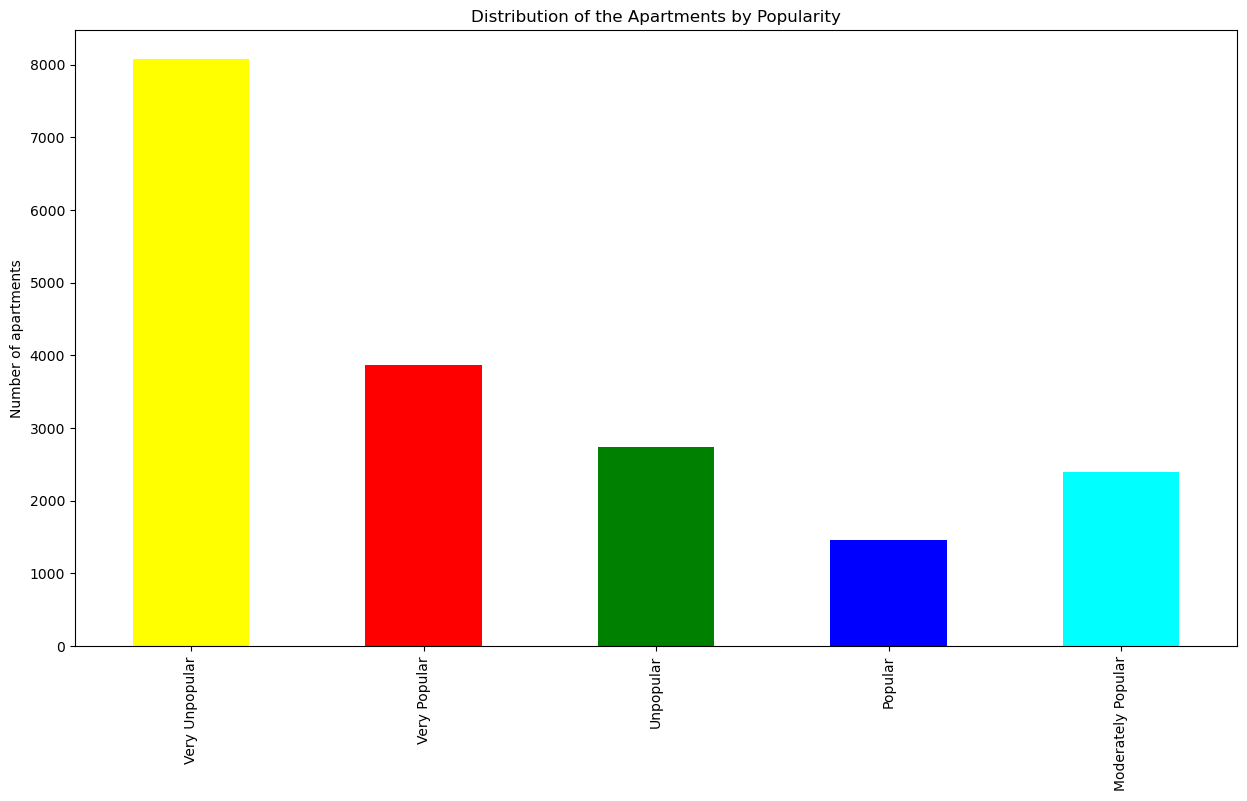

In [5]:
# Bar Plot for a visulization of the distribution of the 5 target classes
plt.rcdefaults()
plt.rcParams["figure.figsize"] = (15,8)
clean_data["Popularity"].value_counts().sort_index(ascending=False).plot(kind="bar",color=['yellow', 'red', 'green', 'blue', 'cyan'])
plt.ylabel("Number of apartments")
plt.title("Distribution of the Apartments by Popularity")

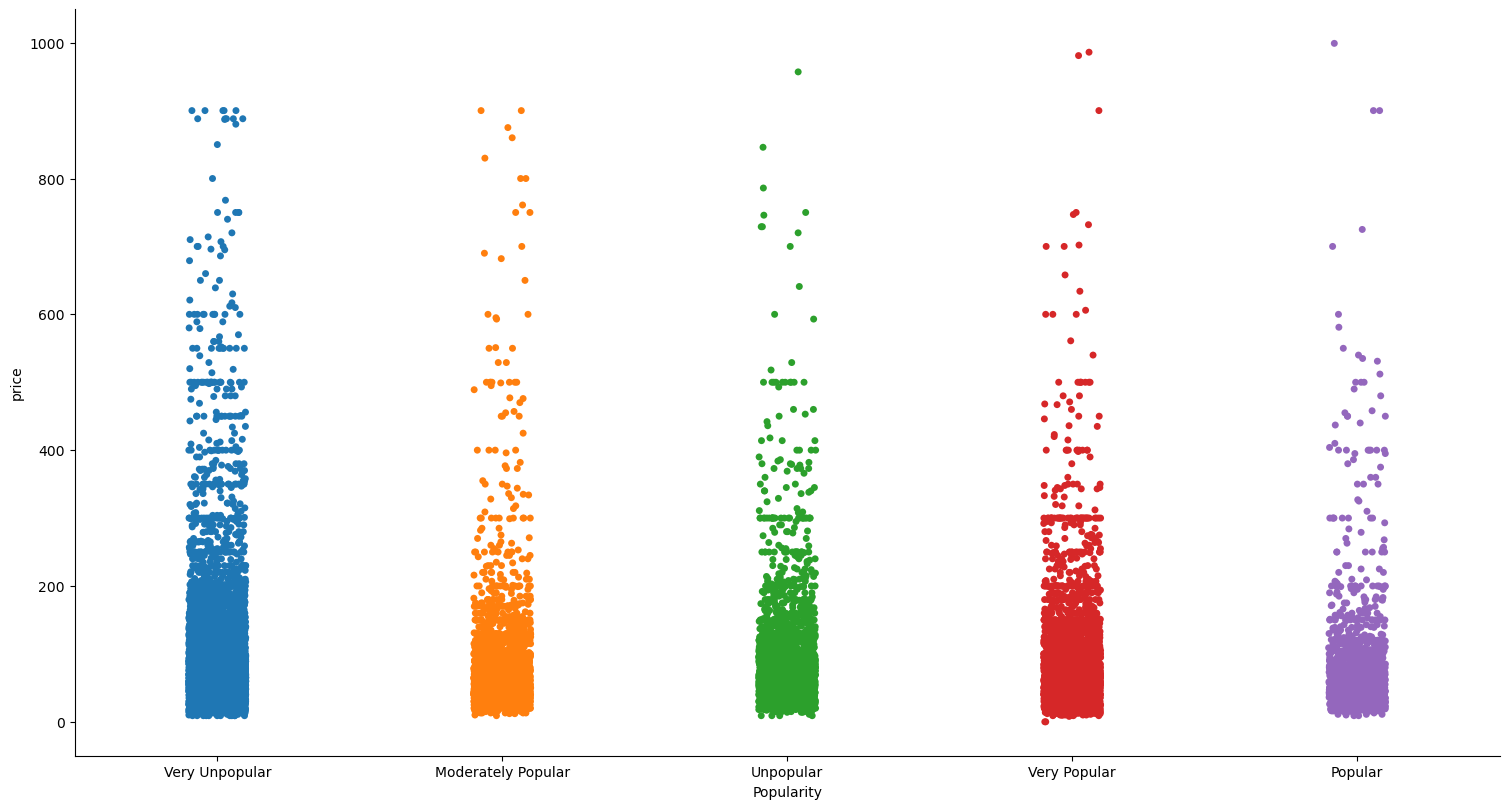

In [6]:
# cat plot of the 5 classes and the respective prices per night
sns.catplot(x="Popularity", y="price", data=clean_data, height=8, aspect=15/8)
xlabel='popularity'
ylabel='price'

Text(0.5, 1.0, 'Reviews scores and Prices')

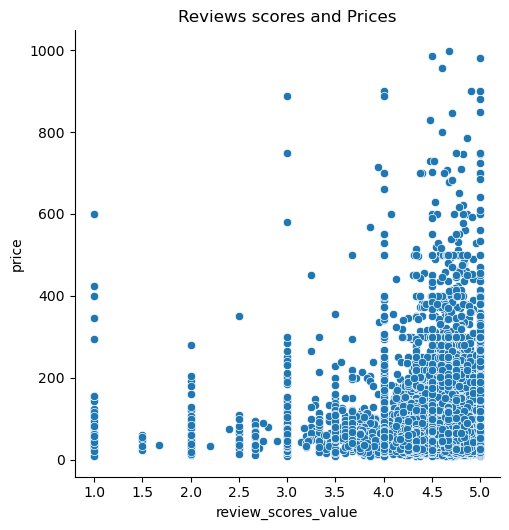

In [9]:
# plot to show the dsitribution of the review scores and the prices
sns.relplot(x="review_scores_value", y="price", data=clean_data)
xlabel='Popularity'
ylabel='price'
plt.title("Reviews scores and Prices")

C:\Users\aleco\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Density Price Distribution')

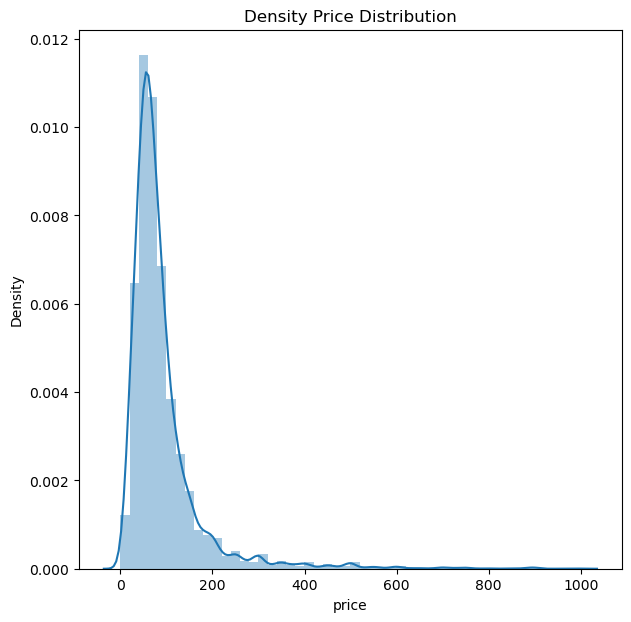

In [11]:
#overall daily price distribution
plt.figure(figsize=(7,7))
sns.distplot(clean_data['price'])
plt.title("Density Price Distribution")

## 3.1 Feature Selection <a class="anchor" id="Feature_Selection"></a>

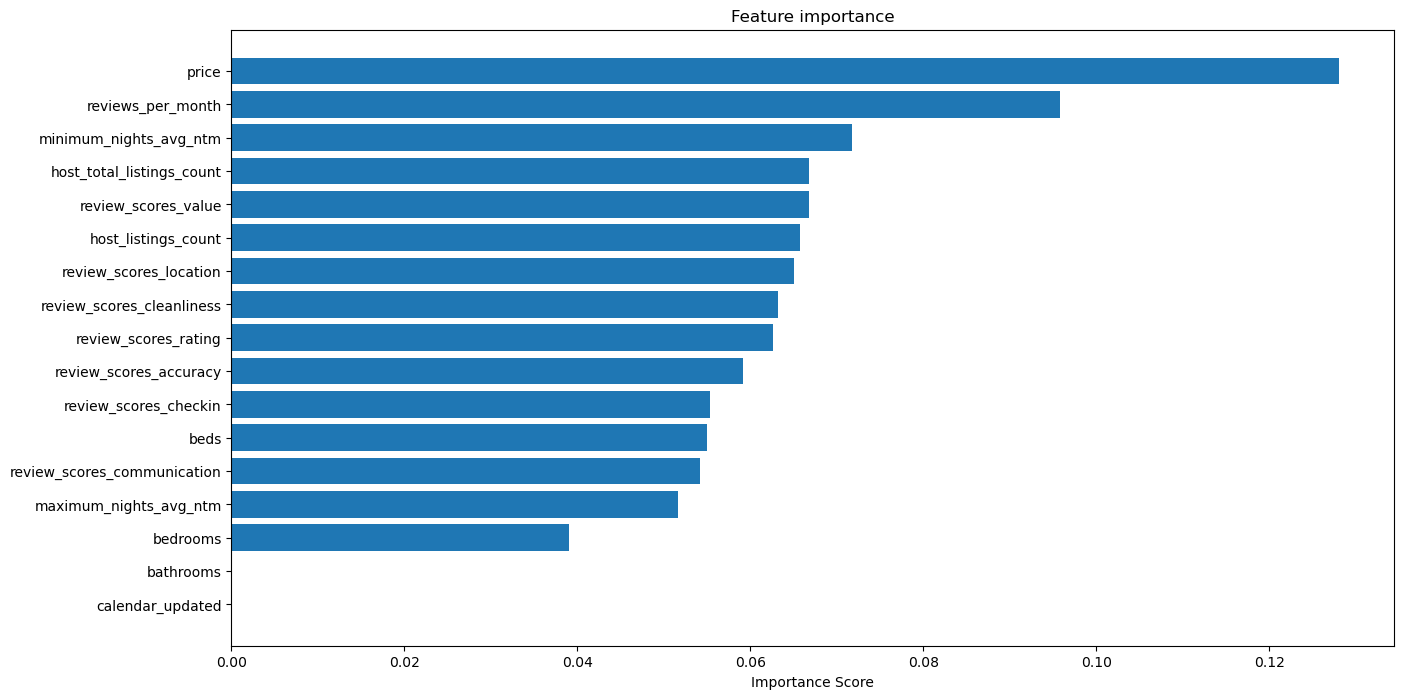

In [12]:
# Features selection based on a Random Forest classifier
X=clean_data.loc[:, clean_data.columns != 'Popularity']
non_floats = []
for col in X:
    if X[col].dtypes != "float64":
        non_floats.append(col)
X = X.drop(columns=non_floats)
y=clean_data["Popularity"]
X=X.fillna(0)
X=X.drop(["latitude","longitude",'popularity score'],axis=1)
X_train,X_test,y_train,_y_test=train_test_split(X,y,test_size=0.2,random_state=0)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
importance=rf.feature_importances_

sorted_idx = importance.argsort()
plt.rcParams["figure.figsize"] = (15,8)
plt.title("Feature importance")
plt.xlabel("Importance Score")
plt.barh(X.columns[sorted_idx],importance[sorted_idx])


## EXTRACT THE MOST IMPORTANT FEATURES based on that score
importance=np.sort(importance)
more_importants=[]
for i in importance:
    if i>=0.06:
        more_importants.append(i)
more_importants;

## 3.2 Correlation <a class="anchor" id="Correlation"></a>

In [13]:
#correlation within best 9 features

top9= clean_data[['price', 'host_listings_count', 'reviews_per_month', 'minimum_nights', 'host_total_listings_count','review_scores_value', 
            'review_scores_location','review_scores_cleanliness','review_scores_rating',"Popularity"]]
top9.corr()

,price,host_listings_count,reviews_per_month,minimum_nights,host_total_listings_count,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_rating
price,1.000000,0.017805,-0.127337,-0.017324,0.017805,0.015162,0.051076,0.049695,0.043339
host_listings_count,0.017805,1.000000,-0.049341,-0.023802,1.000000,-0.137755,-0.054129,-0.131682,-0.124716
reviews_per_month,-0.127337,-0.049341,1.000000,-0.046946,-0.049341,0.130215,0.104229,0.101787,0.116024
minimum_nights,-0.017324,-0.023802,-0.046946,1.000000,-0.023802,0.009670,-0.000193,0.005351,0.004377
host_total_listings_count,0.017805,1.000000,-0.049341,-0.023802,1.000000,-0.137755,-0.054129,-0.131682,-0.124716
review_scores_value,0.015162,-0.137755,0.130215,0.009670,-0.137755,1.000000,0.535739,0.714824,0.841877
review_scores_location,0.051076,-0.054129,0.104229,-0.000193,-0.054129,0.535739,1.000000,0.426410,0.528862
review_scores_cleanliness,0.049695,-0.131682,0.101787,0.005351,-0.131682,0.714824,0.426410,1.000000,0.777581
review_scores_rating,0.043339,-0.124716,0.116024,0.004377,-0.124716,0.841877,0.528862,0.777581,1.000000


In [14]:
# Pearson correlation
from scipy import stats
df_corr = top9
pearsoncorr = df_corr.corr(method='pearson')
pearsoncorr

,price,host_listings_count,reviews_per_month,minimum_nights,host_total_listings_count,review_scores_value,review_scores_location,review_scores_cleanliness,review_scores_rating
price,1.000000,0.017805,-0.127337,-0.017324,0.017805,0.015162,0.051076,0.049695,0.043339
host_listings_count,0.017805,1.000000,-0.049341,-0.023802,1.000000,-0.137755,-0.054129,-0.131682,-0.124716
reviews_per_month,-0.127337,-0.049341,1.000000,-0.046946,-0.049341,0.130215,0.104229,0.101787,0.116024
minimum_nights,-0.017324,-0.023802,-0.046946,1.000000,-0.023802,0.009670,-0.000193,0.005351,0.004377
host_total_listings_count,0.017805,1.000000,-0.049341,-0.023802,1.000000,-0.137755,-0.054129,-0.131682,-0.124716
review_scores_value,0.015162,-0.137755,0.130215,0.009670,-0.137755,1.000000,0.535739,0.714824,0.841877
review_scores_location,0.051076,-0.054129,0.104229,-0.000193,-0.054129,0.535739,1.000000,0.426410,0.528862
review_scores_cleanliness,0.049695,-0.131682,0.101787,0.005351,-0.131682,0.714824,0.426410,1.000000,0.777581
review_scores_rating,0.043339,-0.124716,0.116024,0.004377,-0.124716,0.841877,0.528862,0.777581,1.000000


<AxesSubplot:>

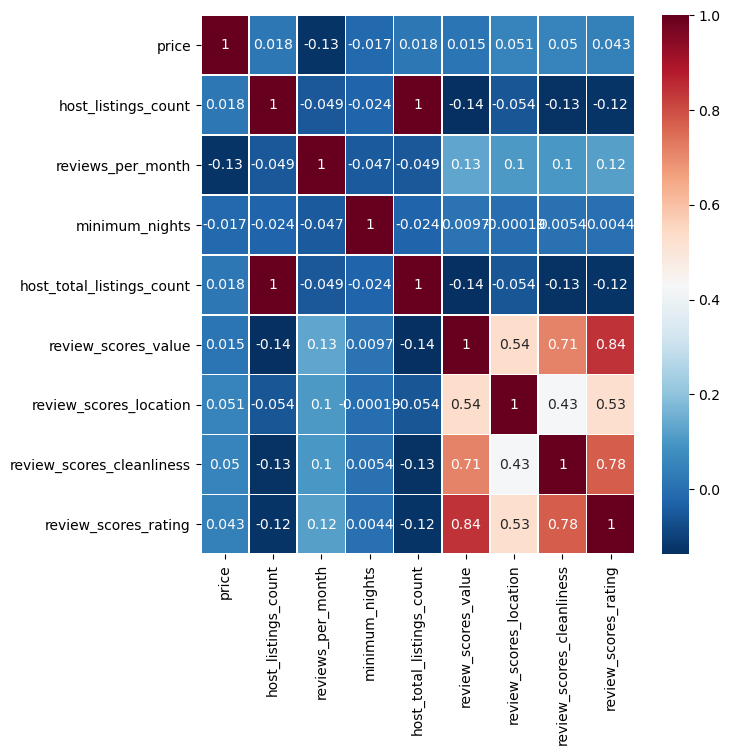

In [15]:
# Heatmap of the top 9 features 
# Since two variables represent the same thing they have a correlation of 1
# For this reason we have decided to don't include one of them in the model
plt.subplots(figsize=(7,7))
sns.heatmap(pearsoncorr,xticklabels=pearsoncorr.columns,yticklabels=pearsoncorr.columns,cmap='RdBu_r',linewidth=0.5, annot=True)

# 4. Data Pre-Processing <a class="anchor" id="Data_Pre-Processing"></a>


In [32]:
temp=clean_data[["price","reviews_per_month","minimum_nights_avg_ntm","review_scores_value",
             'host_listings_count','review_scores_location',
              'review_scores_cleanliness','review_scores_rating','Popularity']].dropna()
temp=temp.sample(n=3000)

X=temp[["price","reviews_per_month","minimum_nights_avg_ntm","review_scores_value",
             'host_listings_count','review_scores_location',
              'review_scores_cleanliness','review_scores_rating']]
y=temp["Popularity"]
lc = LabelEncoder() 
lc = lc.fit(y) 

y= lc.transform(y) # Transfroms the 5 classes in 5 labels from 0 to 4
scaler=StandardScaler().fit(X) # scaled the dataset in order to avoid the problems of distance related algorithm
X=scaler.transform(X)


## 4.1 SMOTE Method <a class="anchor" id="SMOTE_Method"></a>

In [33]:
# smote method to balance the dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE()
# fit predictor and target variable
X, y = smote.fit_resample(X, y)

## 4.2 Train and Test set creation  <a class="anchor" id="Train_Test"></a>

In [34]:
# Cross validation method with different sizes for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42,shuffle=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2,random_state=42,shuffle=True)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.1,random_state=42,shuffle=True)

# 5. Modelling  <a class="anchor" id="Modelling"></a>

# 5.1 Models without Boost  <a class="anchor" id="No_boost"></a>
3 different types of models have been used for the classification:

## 5.1.1 Decision Tree  <a class="anchor" id="Decision_tree"></a>

In [35]:
# Decision Tree Pipeline with standardization and PCA with 3 components
Decision_tree_pipeline=Pipeline([('scaler', StandardScaler()),
                                  ('pca',PCA(n_components=3)),
                       ('dec tree',DecisionTreeClassifier(max_depth=5))])

## 5.1.2 Multiple Logistic Regression  <a class="anchor" id="Multi_logistic_regr"></a>
A multiclass Logistic Regression based on the "one vs rest" method

In [36]:
# Multiclass Logistic Regression with standardization and PCA with 3 components 
LogisticRegressionPipeline=Pipeline([('scaler', StandardScaler()),
                                      ('pca',PCA(n_components=3)),
                       ('log reg', LogisticRegression(multi_class='ovr'))])

## 5.1.3 KNN Method  <a class="anchor" id="knn"></a>

In [25]:
# Error rate of the prediction with different values for k
error_rate = []
for i in range(1,60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

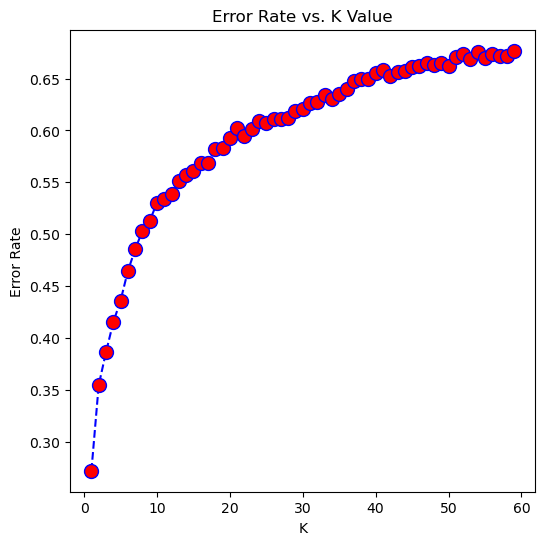

In [37]:
# plot of K value and the corresponding error rate for the dataset.
plt.figure(figsize=(6,6))
plt.plot(range(1,60),error_rate,color="blue", linestyle="dashed", marker="o",
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [28]:
# kNN Pipeline with standardization and PCA with 3 components
KNN_pipeline=Pipeline([('scaler', StandardScaler()),
                       ('pca',PCA(n_components=3)),
                       ('KNN', KNeighborsClassifier(n_neighbors=4))])

## 5.2 Results  <a class="anchor" id="Results"></a>

In [38]:
# List of all the Pipeline with the corrispondent dictionary
mypipeline=[LogisticRegressionPipeline,KNN_pipeline,Decision_tree_pipeline]
PipelineDict={0:"Logistic Regression",1:"KNN",2:"Decision tree"}
# Easy loop to fit the 3 models at once
for i in mypipeline:
    i.fit(X_train,y_train)

In [39]:
# Final accuracies of the 3 models applied
for i, model in enumerate(mypipeline):
    print("{} test accuracy: {}".format(PipelineDict[i],model.score(X_test,y_test)))
    print("{} test accuracy: {}".format(PipelineDict[i],model.score(X_test2,y_test2)))
    print("{} test accuracy: {}".format(PipelineDict[i],model.score(X_test3,y_test3)))
    

Logistic Regression test accuracy: 0.2303001876172608
Logistic Regression test accuracy: 0.23142414860681115
Logistic Regression test accuracy: 0.2260061919504644
KNN test accuracy: 0.44652908067542213
KNN test accuracy: 0.4613003095975232
KNN test accuracy: 0.46439628482972134
Decision tree test accuracy: 0.27110694183864914
Decision tree test accuracy: 0.2654798761609907
Decision tree test accuracy: 0.2739938080495356


# 6. XGBoost Preparation <a class="anchor" id="Preparation"></a>

## 6.1 Hyperparameters Tuning  <a class="anchor" id="Tuning"></a>
Based on the dataset XGBoost Classifier needs some adjustments to perform at its best

In [31]:
## FIT OF THE BEST NUMBER OF DECISION TREES (n_estimators) IN THE MODEL
model= XGBClassifier()
n_estimators = range(50,500,50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X,y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\aleco\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.873606 using {'n_estimators': 250}
-1.067079 (0.027296) with: {'n_estimators': 50}
-0.939040 (0.028440) with: {'n_estimators': 100}
-0.889395 (0.030603) with: {'n_estimators': 150}
-0.876692 (0.032005) with: {'n_estimators': 200}
-0.873606 (0.032174) with: {'n_estimators': 250}
-0.881168 (0.032315) with: {'n_estimators': 300}
-0.890737 (0.032111) with: {'n_estimators': 350}
-0.903252 (0.033355) with: {'n_estimators': 400}
-0.915689 (0.033688) with: {'n_estimators': 450}


In [40]:
## FIT OF THE MAX DEPHT OF EACH DECISION TREE OF THE MODEL based on the standard deviation
model= XGBClassifier()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X,y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

range(1, 11, 2)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


C:\Users\aleco\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.782298 using {'max_depth': 9}
-1.506356 (0.009921) with: {'max_depth': 1}
-1.233191 (0.028631) with: {'max_depth': 3}
-0.990154 (0.038276) with: {'max_depth': 5}
-0.832601 (0.043611) with: {'max_depth': 7}
-0.782298 (0.050282) with: {'max_depth': 9}


In [41]:
# Other hyperparameters tuning for then XGBoost model
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [ 1, 1.5, 2],
        'max_depth': [9],
        'reg_lambda': [10,20,30],
        'learning_rate': [0.1, 0.3, 0.5]
        }

xgb= XGBClassifier(objective='multi:softprob',
                     num_class= 5,
                     subsample=0.8,
                     colsample_bytree=0.5,
                     use_label_encoder=False)
optimal_params=GridSearchCV(estimator=xgb,
                           param_grid=params,
                           scoring='roc_auc',
                           verbose=0,
                           n_jobs=10,
                           cv=3)
optimal_params.fit(X_train,
                   y_train,
                   early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_test,y_test)],
                  verbose=False);


C:\Users\aleco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [60]:
# Optimal Parameters
print(optimal_params.best_params_)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'reg_lambda': 10}


## 7. XGBoost in action <a class="" id="Action"></a>

In [42]:
# Final XGClassifier model with the optimal parameters
model= XGBClassifier(n_estimators=250,
                     max_depth=9,
                     objective='multi:softprob',
                     num_class= 5,
                     eval_metric='mlogloss',
                     gamma=1,
                     min_child_weight=1,
                     learning_rate=0.1,
                     reg_lambda=10,
                     use_label_encoder=False)

model.fit(X_train, y_train)
train_pred=model.predict(X_train)
train_acc=accuracy_score(train_pred,y_train)   

model.fit(X_train, y_train)
model.fit(X_train2,y_train2)
model.fit(X_train3,y_train3)
y_pred = model.predict(X_test) 
y_pred2=model.predict(X_test2)
y_pred3=model.predict(X_test3)
acc = accuracy_score(y_test, y_pred) 
acc2=accuracy_score(y_test2,y_pred2)
acc3=accuracy_score(y_test3,y_pred3)

print("Train Accuracy: {:.3f}%".format(train_acc*100))

Train Accuracy: 93.808%


## 7.1 Results from Boosting <a class="anchor" id="Results_Boosting"></a>

In [43]:
print("Test Accuracy: %.3f%%" % (acc * 100.0)) 
print("Test Accuracy: %.3f%%" % (acc2 * 100.0)) 
print("Test Accuracy: %.3f%%" % (acc3 * 100.0)) 

Test Accuracy: 84.193%
Test Accuracy: 78.638%
Test Accuracy: 64.087%


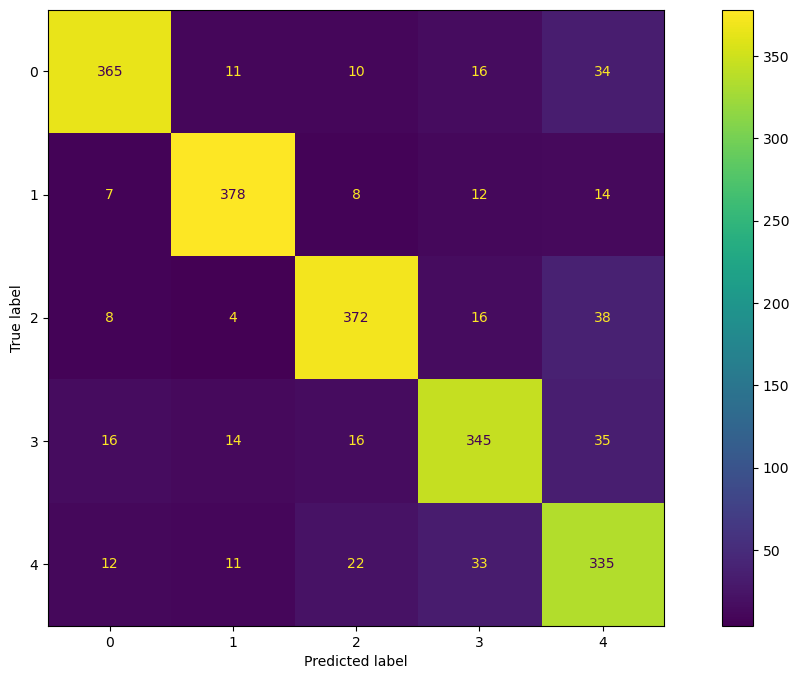

In [44]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
conf_mat = confusion_matrix(y_test, y_pred,labels=model.classes_)
disp=ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=model.classes_)
disp.plot()

In [45]:
# Confusion Matrix with probabilities
conf_mat_prob=pd.DataFrame(conf_mat).div(conf_mat.sum(axis=1),axis=0)
conf_mat_prob

,0,1,2,3,4
0,0.837156,0.025229,0.022936,0.036697,0.077982
1,0.016706,0.902148,0.019093,0.028640,0.033413
2,0.018265,0.009132,0.849315,0.036530,0.086758
3,0.037559,0.032864,0.037559,0.809859,0.082160
4,0.029056,0.026634,0.053269,0.079903,0.811138


In [46]:
## Other Types of Metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
def print_metrics(labels, preds):
    print("Precision Score: {:.4f}".format(precision_score(labels, preds,average="macro")))
    print("Recall Score: {:.4f}".format(recall_score(labels, preds,average="macro")))
    print("Accuracy Score: {:.4f}".format(accuracy_score(labels, preds)))
    print("F1 Score: {:.4f}".format(f1_score(labels, preds,average="macro")))
print_metrics(y_test,y_pred)

Precision Score: 0.8441
Recall Score: 0.8419
Accuracy Score: 0.8419
F1 Score: 0.8424


In [47]:
# ROC-AUC metric with different values
from sklearn.metrics import roc_auc_score
from sklearn import metrics
y_prob = model.predict_proba(X_test) # return probability class for each data point

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_test, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_test, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)


One-vs-One ROC AUC scores:
0.966618 (macro),
0.966641 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.966619 (macro),
0.966680 (weighted by prevalence)


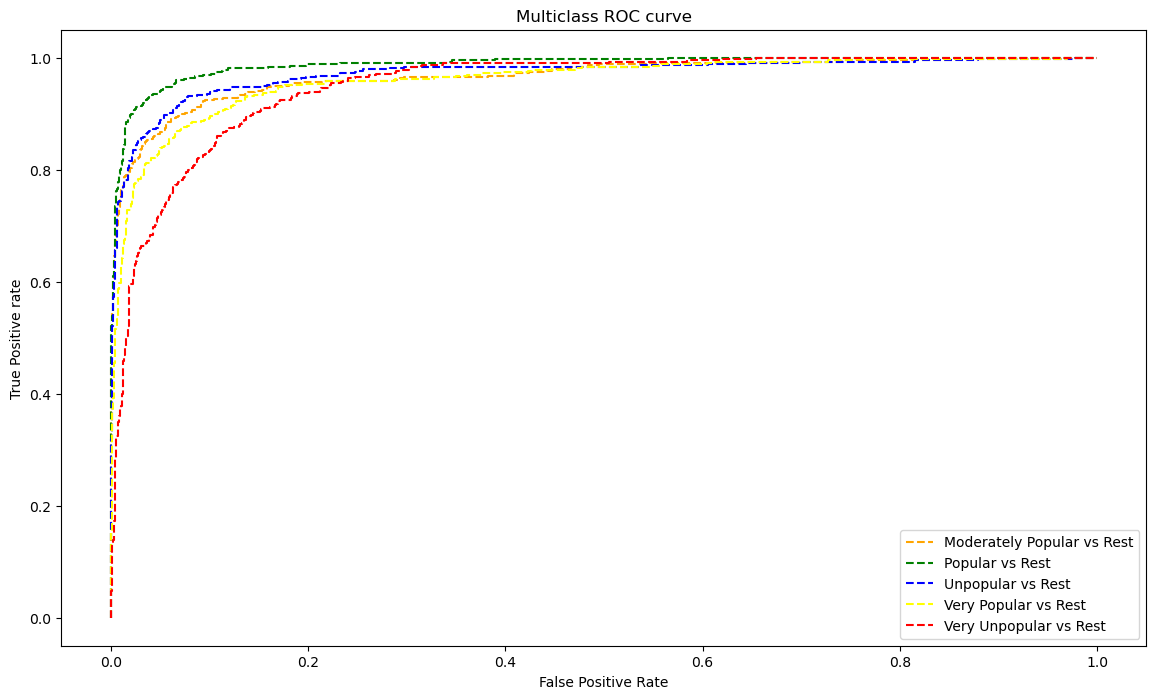

In [49]:
# ROC-AUC Plot
from sklearn.metrics import roc_curve, roc_auc_score
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)
    
# plotting   
plt.figure(figsize=(14,8))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Moderately Popular vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Popular vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Unpopular vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Very Popular vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Very Unpopular vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')  

# 8. Conclusion <a class="anchor" id="Conclusion"></a>
With these excellent accuracy values, it is possible to confirm that a future flat listed on the platform will be correctly classified according to its popularity and this can create an a priori advantage for the company and for the host who will be able to estimate how long his apartment will remain rented during the year.